# Part 2 - GRU

## Imports

In [4]:
import torch 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import json
import gensim
import re
import torch.optim as optim
from torchtext.vocab import GloVe, FastText
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load processed data

In [5]:
with open('../data_processed/LR_train_tagged.json') as f: 
    LR_train = json.load(f)
    
with open('../data_processed/LR_test_tagged.json') as f:
    LR_test = json.load(f)
    
with open('../data_processed/LR_val_tagged.json') as f:
    LR_val = json.load(f)

with open('../data_processed/NER_train_tagged.json') as f:
    NER_train = json.load(f)

with open('../data_processed/NER_test_tagged.json') as f:
    NER_test = json.load(f)

with open('../data_processed/NER_val_tagged.json') as f:
    NER_val = json.load(f)


## Load vector embedding models

### Word2Vec


In [6]:
w2vmodel = KeyedVectors.load_word2vec_format('../.vector_cache/GoogleNews-vectors-negative300.bin', binary=True)

### GloVe


In [7]:
# glovemodel = GloVe(name='6B', dim=300)
glove_file = '../.vector_cache/glove.6B.300d.txt'
glovemodel = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glovemodel[word] = vector


### Fasttext

In [8]:
# fasttextmodel = FastText()
fasttext_file = '../.vector_cache/wiki.en.vec'
fastmodel = {}
with open(fasttext_file, 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.array([x for x in values[1:] if x], dtype='float32')
        fastmodel[word] = vector

## Creating and Training the Models

### Create list of unique labels - NER

In [9]:
unique_labels = []
for entry in NER_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_NER = {}
unique_labels = list(set(unique_labels))
unique_labels = sorted(unique_labels)

for label_index in range(len(unique_labels)):
    label_dict_NER[unique_labels[label_index]] = label_index

# label_dict_NER['p0p'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1

output_dict = {}
for key, value in label_dict_NER.items():
    new_key = key.replace('B_', '').replace('I_', '')
    if new_key not in output_dict:
        output_dict[new_key] = len(output_dict)

label_dict_NER = output_dict
label_dict_NER

{'CASE_NUMBER': 0,
 'COURT': 1,
 'DATE': 2,
 'GPE': 3,
 'JUDGE': 4,
 'ORG': 5,
 'OTHER_PERSON': 6,
 'PETITIONER': 7,
 'PRECEDENT': 8,
 'PROVISION': 9,
 'RESPONDENT': 10,
 'STATUTE': 11,
 'WITNESS': 12,
 'O': 13}

### Create list of unique labels - LR

In [10]:
unique_labels = []
for entry in LR_train:
    labels = entry['labels']
    for label in labels:
        unique_labels.append(label)

label_dict_LR = {}
unique_labels = list(set(unique_labels))
unique_labels = sorted(unique_labels)

for label_index in range(len(unique_labels)):
    label_dict_LR[unique_labels[label_index]] = label_index

# label_dict_LR['p0p'] = len(unique_labels)
# label_dict['UNK'] = len(unique_labels) + 1
label_dict_LR

{'B': 0, 'I': 1, 'O': 2}

### Verifying LR_train

In [11]:
# id = 0
# for entry in LR_train:
#     if (len(entry['text'].split()) != len(entry['labels'])):
#         print(entry['id'])
#         print(len(entry['text'].split()))
#         print(len(entry['labels']))

### Define NER dataset class

In [12]:
class NER_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "O"
        # self.padding_word = "p0p"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)
            
        self.data = dataset
        self.input = []
        self.labels = []
        
        for i in range(len(self.data)):
            lst = self.data[i]["labels"]
            for j in range(len(lst)):
                if lst[j].startswith("B_"):
                    lst[j] = lst[j][2:]
                elif lst[j].startswith("I_"):
                    lst[j] = lst[j][2:]
            self.data[i]["labels"] = lst

        if padding:
            for entry in self.data:
                padded_entry = entry["text"].split() + [self.padding_word] * (75 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (75 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in self.data:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_NER

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []
        
        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Define LR Dataset class

In [13]:
class LR_dataset(Dataset):
    def __init__(self, dataset, embedding="word2vec", padding=True):
        self.padding_word = "O"

        if embedding == "word2vec":
            self.model = w2vmodel
            self.model.add_vector(self.padding_word, np.zeros(300))
        elif embedding == "glove":
            self.model = glovemodel
            self.model[self.padding_word] = np.zeros(300)
        else:
            self.model = fastmodel
            self.model[self.padding_word] = np.zeros(300)

        self.data = dataset
        self.input = []
        self.labels = []
        if padding:
            for entry in dataset:
                padded_entry = entry["text"].split() + [self.padding_word] * (78 - len(entry["text"].split()))
                self.input.append(padded_entry)
                padded_labels = entry["labels"] + [self.padding_word] * (78 - len(entry["labels"]))
                self.labels.append(padded_labels)
        else:
            for entry in dataset:
                self.input.append(entry["text"].split())
                self.labels.append(entry["labels"])
        self.tag_to_index = label_dict_LR

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        sentence = self.input[idx]
        word_vecs = []
        labels = []

        # for word_index in range(len(sentence)):
        #     if sentence[word_index] not in self.model:
        #         word_vecs.append(np.zeros(300))
        #         labels.append(self.tag_to_index["O"])
        #         continue
        #     else:
        #         word_vecs.append(self.model[sentence[word_index]])
        #         labels.append(self.tag_to_index[self.labels[idx][word_index]])

        for word_index in range(len(sentence)):
            word = sentence[word_index]
            if word in self.model:
                word_vecs.append(self.model[word])
            else:
                word_vecs.append(self.model[self.padding_word])
            labels.append(self.tag_to_index[self.labels[idx][word_index]])

        return torch.tensor(word_vecs), torch.tensor(labels)

### Training Loop

In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    train_accuracy_scores = []
    val_accuracy_scores = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        all_val_labels = []
        all_val_preds = []

        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            outputs, hn = model(inputs)
            outputs = outputs.reshape(-1, outputs.shape[-1])
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
        train_accuracy_scores.append(train_accuracy)
        train_f1_scores.append(train_f1)

        model.eval()
        with torch.no_grad():

            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs, hn = model(inputs)
                outputs = outputs.reshape(-1, outputs.shape[-1])
                labels = labels.reshape(-1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

            val_accuracy = accuracy_score(all_val_labels, all_val_preds)
            val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
            val_accuracy_scores.append(val_accuracy)
            val_f1_scores.append(val_f1)

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch {epoch + 1}\n"
              f"Train loss: {train_losses[-1]}, Val loss: {val_losses[-1]}\n"
              f"Train accuracy: {train_accuracy}, Val accuracy: {val_accuracy}\n"
              f"Train F1: {train_f1}, Val F1: {val_f1}")
        print("=====================================================================================================")

    return model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores
        

### Modified NN models

In [15]:
class SequentialModel(nn.Module):
    def __init__(self, label_dict, base_model):
        super().__init__()
        self.rnn = base_model
        self.fc = nn.Linear(128, len(label_dict))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = self.fc(x)
        x = self.softmax(x)
        
        return x, hn

## Word2Vec Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [16]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "word2vec", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "word2vec", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "word2vec", padding=True), batch_size=64, shuffle=True)

c:\Users\Jaskaran\miniconda3\envs\mlenv\lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [17]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "word2vec", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "word2vec", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "word2vec", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [18]:
model = SequentialModel(label_dict_NER, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [19]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t1_gru_word2vec.pt")

C:\Users\Jaskaran\AppData\Local\Temp\ipykernel_18876\4087966327.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(word_vecs), torch.tensor(labels)


Epoch 1
Train loss: 2.622768534827478, Val loss: 2.618612724192002
Train accuracy: 0.587245531616178, Val accuracy: 0.677394777265745
Train F1: 0.14720343167078348, Val F1: 0.1803910239521888
Epoch 2
Train loss: 2.6181258884901855, Val loss: 2.61793449345757
Train accuracy: 0.6550202494735137, Val accuracy: 0.6618003072196621
Train F1: 0.1745196217888972, Val F1: 0.17266007391227783
Epoch 3
Train loss: 2.617319175877522, Val loss: 2.6175763887517594
Train accuracy: 0.6685285382580053, Val accuracy: 0.6808233486943165
Train F1: 0.17738934269558918, Val F1: 0.18235833608126445
Epoch 4
Train loss: 2.616822503276707, Val loss: 2.6174605032976936
Train accuracy: 0.6971132350558885, Val accuracy: 0.6824700460829493
Train F1: 0.1882699102673353, Val F1: 0.18478967123087683
Epoch 5
Train loss: 2.6164623658681654, Val loss: 2.6173946015975056
Train accuracy: 0.7119822884605, Val accuracy: 0.7267096774193549
Train F1: 0.20014587262975717, Val F1: 0.1981398121691953


In [20]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.7099131944444445 Test F1: 0.18994702891710866


### Plots

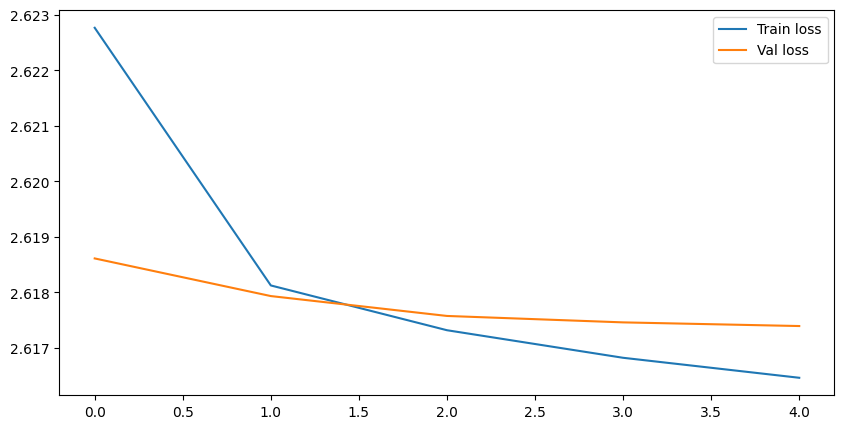

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

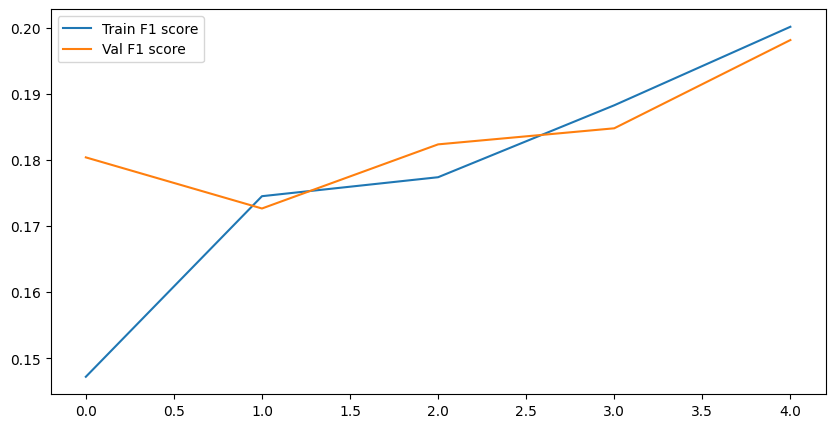

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

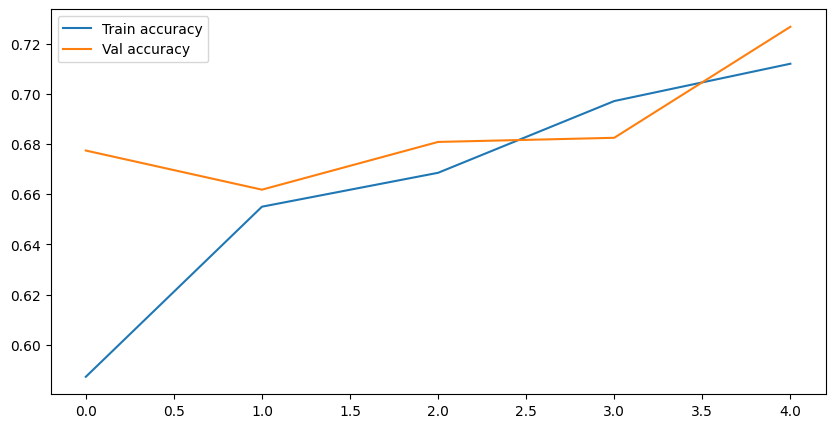

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training and Testing

In [24]:
model = SequentialModel(label_dict_LR, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [25]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t2_gru_word2vec.pt")

Epoch 1
Train loss: 1.0957289457321167, Val loss: 1.0919610500335692
Train accuracy: 0.7638110601686761, Val accuracy: 0.8156732891832229
Train F1: 0.3742069392701722, Val F1: 0.4432367692745533
Epoch 2
Train loss: 1.0893642584482828, Val loss: 1.087438742319743
Train accuracy: 0.8670968472292976, Val accuracy: 0.89447840606781
Train F1: 0.47859290611789235, Val F1: 0.5076873112613759
Epoch 3
Train loss: 1.0871526956558228, Val loss: 1.086288332939148
Train accuracy: 0.909053602762212, Val accuracy: 0.9202750891492614
Train F1: 0.5308936354669428, Val F1: 0.5573762977980488
Epoch 4
Train loss: 1.0860142310460408, Val loss: 1.0857619841893513
Train accuracy: 0.9236854021622234, Val accuracy: 0.9267136469123224
Train F1: 0.5614125744300568, Val F1: 0.5725596330639805
Epoch 5
Train loss: 1.0853596687316895, Val loss: 1.0848716656366983
Train accuracy: 0.9237561555442351, Val accuracy: 0.9249165110092262
Train F1: 0.5744509426547509, Val F1: 0.5844758307639958


In [26]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9249165110092262 Test F1: 0.5844758307639958


### Plots

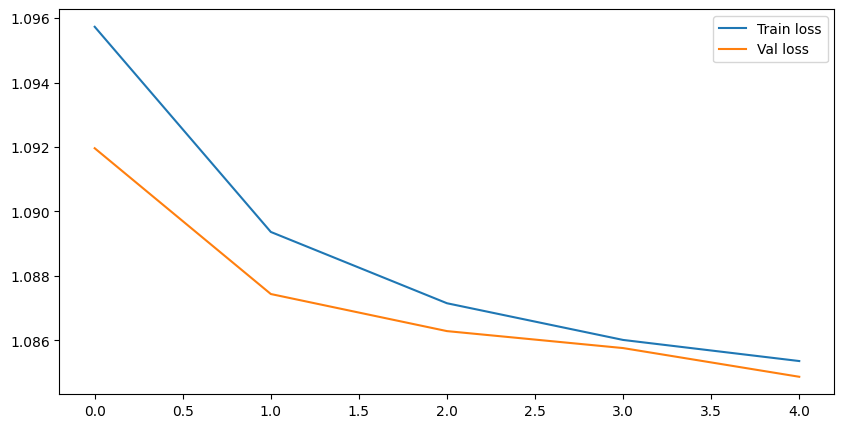

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

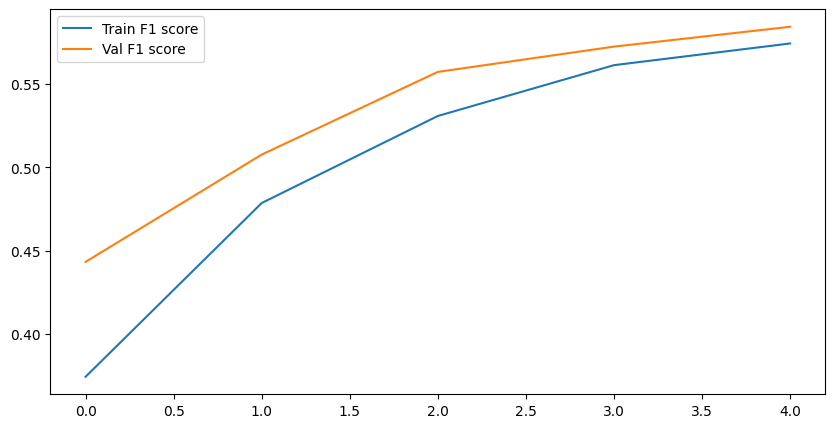

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

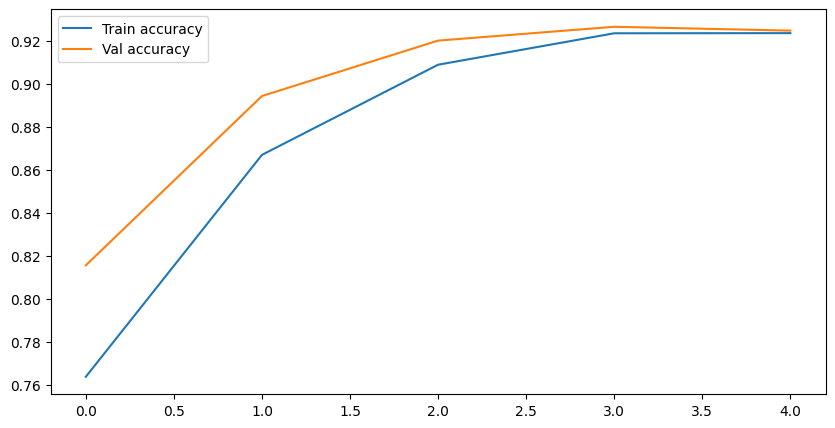

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

## GloVe Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [30]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "glove", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "glove", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "glove", padding=True), batch_size=64, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [31]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "glove", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "glove", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "glove", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [32]:
model = SequentialModel(label_dict_NER, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [33]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t1_gru_glove.pt")

Epoch 1
Train loss: 2.6261047505840813, Val loss: 2.623233262230368
Train accuracy: 0.6545796209298558, Val accuracy: 0.6966390168970814
Train F1: 0.13116105519865442, Val F1: 0.1634463473614489
Epoch 2
Train loss: 2.622372728033164, Val loss: 2.622383678660673
Train accuracy: 0.6888557697499865, Val accuracy: 0.7236497695852535
Train F1: 0.16316804022089354, Val F1: 0.16808274089093372
Epoch 3
Train loss: 2.621426166947355, Val loss: 2.622010076747221
Train accuracy: 0.7125179545331821, Val accuracy: 0.7210568356374808
Train F1: 0.1760446763531481, Val F1: 0.16721817863203242
Epoch 4
Train loss: 2.6207760756777736, Val loss: 2.62183513360865
Train accuracy: 0.7226221718235326, Val accuracy: 0.730494623655914
Train F1: 0.18096287816751055, Val F1: 0.17849149149811572
Epoch 5
Train loss: 2.6203107538911485, Val loss: 2.621566618190092
Train accuracy: 0.7265640693341973, Val accuracy: 0.7415176651305684
Train F1: 0.18317537602571732, Val F1: 0.17691004255137766


In [34]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.7290451388888889 Test F1: 0.17025515628056528


### Plots

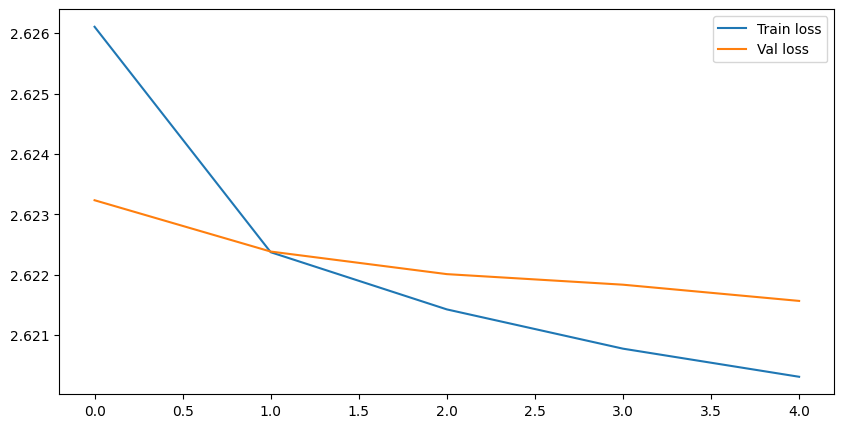

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

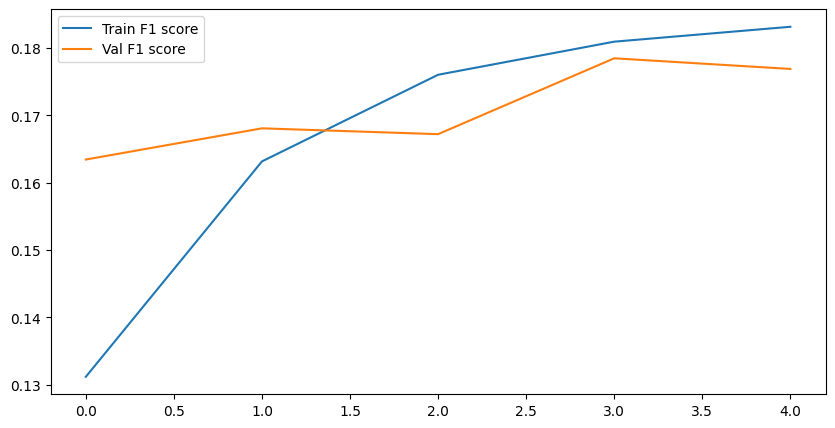

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

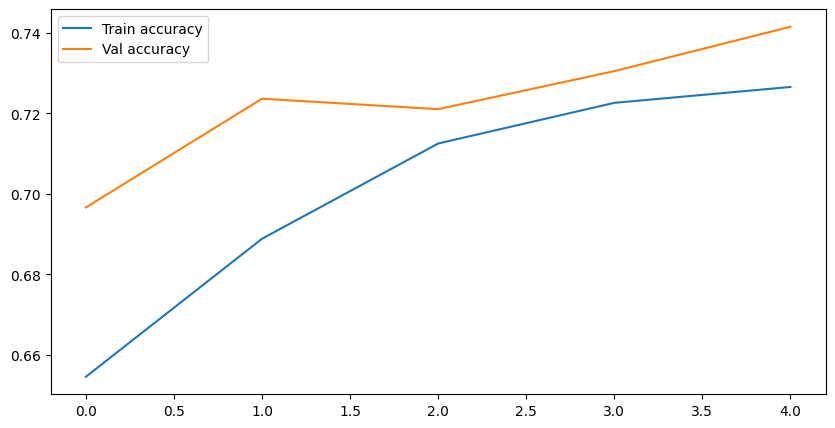

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training

In [38]:
model = SequentialModel(label_dict_LR, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [39]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t2_gru_glove.pt")

Epoch 1
Train loss: 1.0950377543767293, Val loss: 1.0908898035685222
Train accuracy: 0.7114252561272428, Val accuracy: 0.8227344767079866
Train F1: 0.34220812499694625, Val F1: 0.45041800849217156
Epoch 2
Train loss: 1.0896519343058269, Val loss: 1.0881553570429483
Train accuracy: 0.8465217637403067, Val accuracy: 0.8671534499349068
Train F1: 0.4596773716836835, Val F1: 0.4716795151873174
Epoch 3
Train loss: 1.0877917687098184, Val loss: 1.087039589881897
Train accuracy: 0.86899303786721, Val accuracy: 0.8793937850229241
Train F1: 0.47467113921374615, Val F1: 0.5020028372865052
Epoch 4
Train loss: 1.0867470979690552, Val loss: 1.0863582372665406
Train accuracy: 0.8795211411105451, Val accuracy: 0.8747665138393615
Train F1: 0.5026897385046211, Val F1: 0.5005582574486764
Epoch 5
Train loss: 1.0860000212987264, Val loss: 1.0857767581939697
Train accuracy: 0.8889879436237053, Val accuracy: 0.9111620535461595
Train F1: 0.5144266654067705, Val F1: 0.5474931354035025


In [40]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.9111620535461595 Test F1: 0.5474931354035025


### Plots

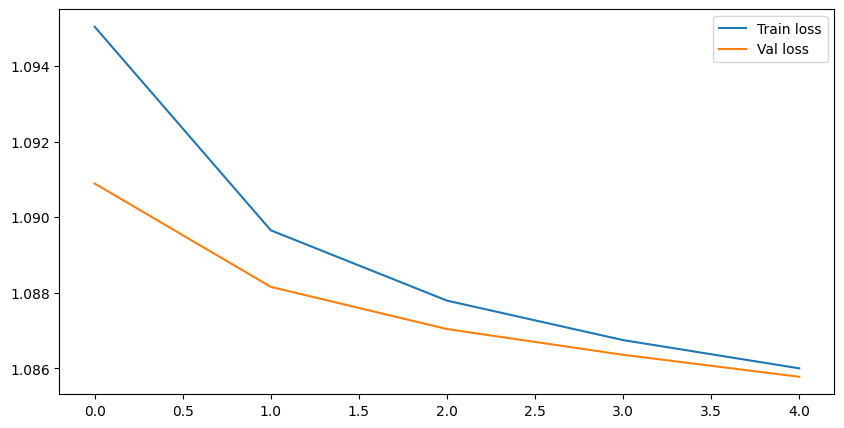

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

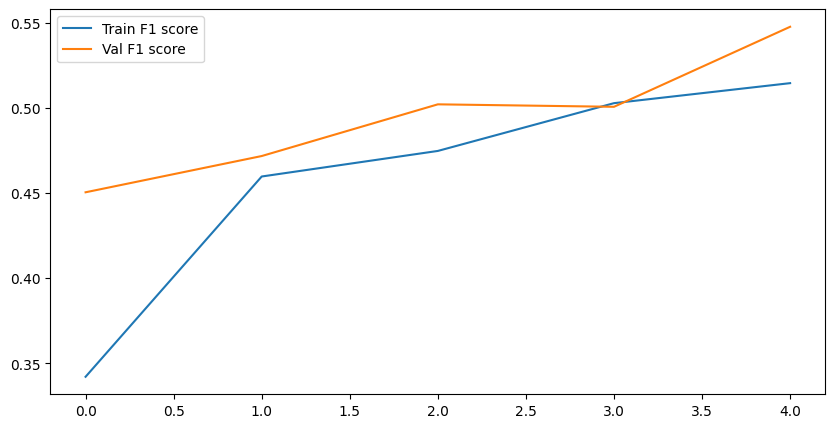

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

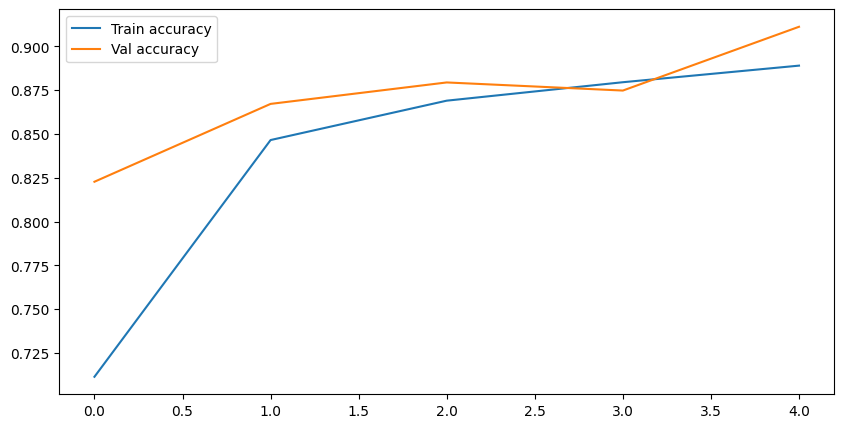

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

## Fasttext Model

### Create batched and shuffled loaders for **Training, Validation and Testing** - NER

In [44]:
NER_train_loader = DataLoader(NER_dataset(NER_train, "fasttext", padding=True), batch_size=64, shuffle=True)
NER_val_loader = DataLoader(NER_dataset(NER_val, "fasttext", padding=True), batch_size=64, shuffle=True)
NER_test_loader = DataLoader(NER_dataset(NER_test, "fasttext", padding=True), batch_size=64, shuffle=True)

### Create batched and shuffled loaders for **Training, Validation and Testing** - LR

In [45]:
LR_train_loader = DataLoader(LR_dataset(LR_train, "fasttext", padding=True), batch_size=64, shuffle=True)
LR_val_loader = DataLoader(LR_dataset(LR_val, "fasttext", padding=True), batch_size=64, shuffle=True)
LR_test_loader = DataLoader(LR_dataset(LR_test, "fasttext", padding=True), batch_size=64, shuffle=True)

### Prepare modified model, criterion, optimizer

In [46]:
model = SequentialModel(label_dict_NER, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### NER Training and Testing

In [47]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, NER_train_loader, NER_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t1_gru_fasttext.pt")

Epoch 1
Train loss: 2.6276244551865098, Val loss: 2.6244509781108185
Train accuracy: 0.6701225768130029, Val accuracy: 0.7360491551459294
Train F1: 0.130319879965861, Val F1: 0.1622582420090394
Epoch 2
Train loss: 2.62345113705114, Val loss: 2.6229092794306137
Train accuracy: 0.7244797235271883, Val accuracy: 0.7732350230414746
Train F1: 0.15506547306007468, Val F1: 0.17430337508413013
Epoch 3
Train loss: 2.622402377964295, Val loss: 2.62278011265923
Train accuracy: 0.7324628759652249, Val accuracy: 0.736073732718894
Train F1: 0.1661842859655279, Val F1: 0.17012501054330814
Epoch 4
Train loss: 2.6217614350859653, Val loss: 2.622653736787684
Train accuracy: 0.7550645283222637, Val accuracy: 0.7638095238095238
Train F1: 0.1838137485626706, Val F1: 0.18064199891014504
Epoch 5
Train loss: 2.621275363509188, Val loss: 2.622409526039572
Train accuracy: 0.7561920190075058, Val accuracy: 0.7287496159754224
Train F1: 0.18859776789000543, Val F1: 0.1817824808338049


In [48]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in NER_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.72671875 Test F1: 0.1847259154792276


### Plots

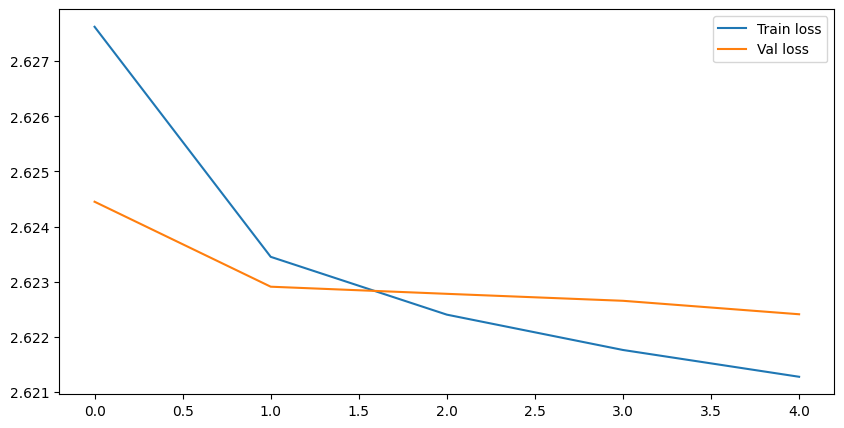

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

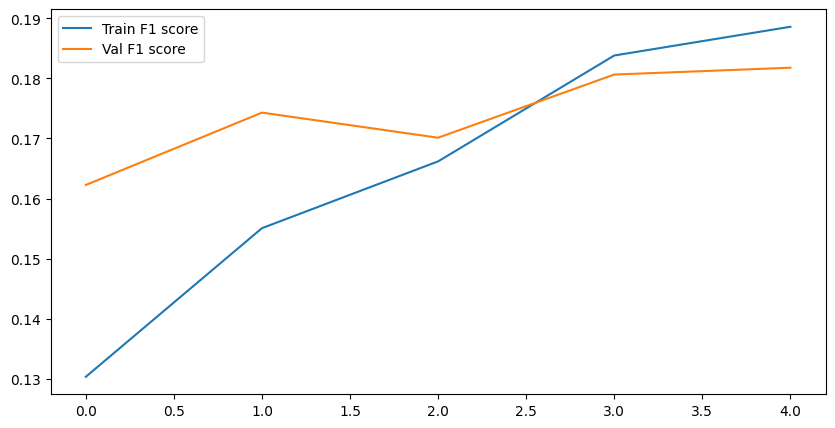

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

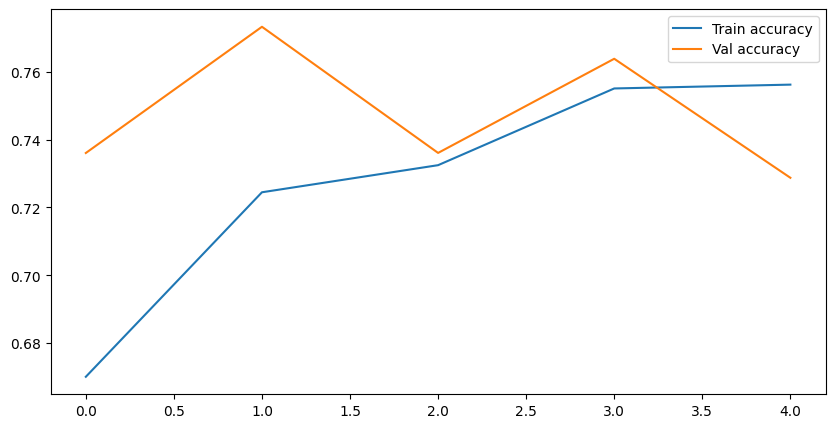

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()

### LR Training and Testing

In [52]:
model = SequentialModel(label_dict_LR, torch.nn.GRU(300, 128, 1, batch_first=True))
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [53]:
model, train_losses, val_losses, train_f1_scores, val_f1_scores, train_accuracy_scores, val_accuracy_scores = \
train(model, LR_train_loader, LR_val_loader, criterion, optimizer, num_epochs=5)
torch.save(model, "../trained_models/t2_gru_fasttext.pt")

Epoch 1
Train loss: 1.0952339887619018, Val loss: 1.090961257616679
Train accuracy: 0.7313918605309334, Val accuracy: 0.8238382294673685
Train F1: 0.35756004192654944, Val F1: 0.43888073144833273
Epoch 2
Train loss: 1.0894917090733847, Val loss: 1.0880099455515544
Train accuracy: 0.8712854474443879, Val accuracy: 0.8529037187977585
Train F1: 0.4654587029686774, Val F1: 0.4564967733215646
Epoch 3
Train loss: 1.0876558065414428, Val loss: 1.0871328671773275
Train accuracy: 0.8634318220410936, Val accuracy: 0.8792805796117055
Train F1: 0.4717578775845015, Val F1: 0.49230709537440287
Epoch 4
Train loss: 1.0869568824768066, Val loss: 1.0864073038101196
Train accuracy: 0.8778089092658629, Val accuracy: 0.8593422765608196
Train F1: 0.49290226337591836, Val F1: 0.49157262472443586
Epoch 5
Train loss: 1.0865919828414916, Val loss: 1.0859262784322103
Train accuracy: 0.8615922341087904, Val accuracy: 0.8570215656308372
Train F1: 0.494435681530861, Val F1: 0.4913847705465759


In [54]:
model.eval()
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for inputs, labels in LR_test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        outputs, hn = model(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        labels = labels.reshape(-1)

        _, predicted = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
print(f"Test accuracy: {test_accuracy} Test F1: {test_f1}")

Test accuracy: 0.8570215656308372 Test F1: 0.4913847705465759


### Plots

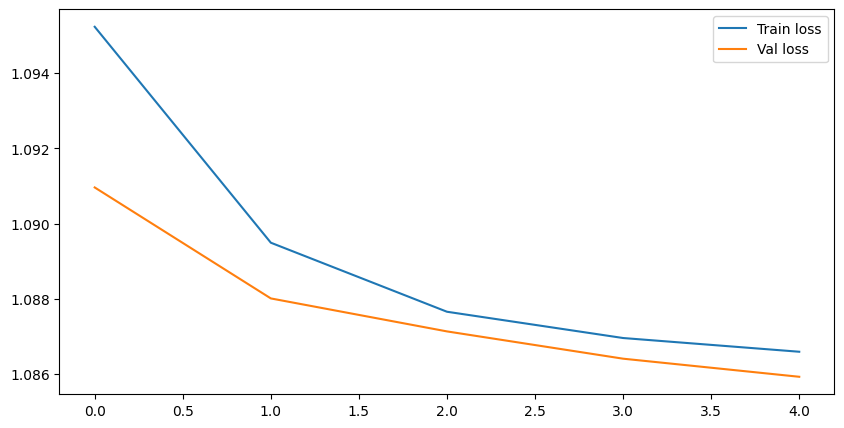

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()

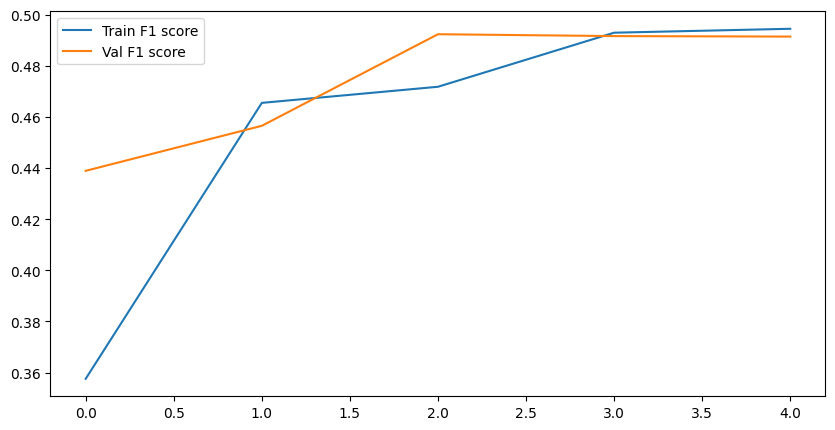

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label="Train F1 score")
plt.plot(val_f1_scores, label="Val F1 score")
plt.legend()

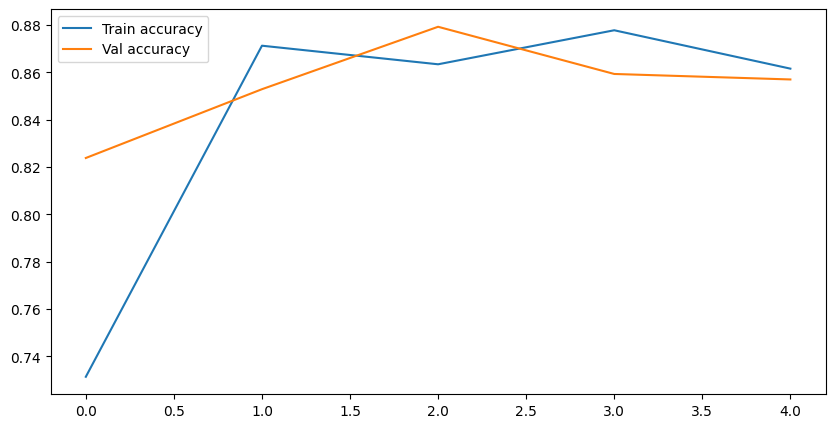

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_scores, label="Train accuracy")
plt.plot(val_accuracy_scores, label="Val accuracy")
plt.legend()